In [1]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [2]:
# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
recalculate = True
recalculate_MC = True
revisualise = True
redo_diagrams = False

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 5 # because running on codespace (see the results for 10000 iterations)
scale_percent = 0.3
dist_id = 3 # normal - 2 is lognormal 
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity
scenario_name = "base_case"
scenarios = {
    'SubstitutionAmountsSensitivity': True,
    "CoproductsToWaste": False,
    "EnergyEfficient": False,
    "WaterEfficient": False,
    "CoproductsToLowerMarket": False,
}

In [3]:
# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 06/01/2023 15:41:15
  Finished: 06/01/2023 15:41:15
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.33
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-06-01T15:41:15.862408', 'geocollections': [], 'searchable': True, 'processed': '2023-06-01T15:41:15.899732', 'dirty': False}

   ACTIVITY:  
*****************************
Purification (bread) : kg : Purification (bread)
----------------------------
	TECHNOSPHERE EXCHANGES: 8
 *  Exchange: -5.772 kilogram 'market for soybean meal' (kilogram, RoW, None) to 'Purification (bread)' (kg, None, None)>
 *  Exchange: 0.042 kilogram 'market for hydrochloric acid, without water, in 30% solution state' (kilogram, RER, None) to 'Purification (bread)' (kg, 

In [4]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'SubstitutionAmountsSensitivity':
                factor = 0.5
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                edge[0]['amount'] *= factor
                print(f"Changed co-products substitution amout by a factor of {factor}: {edge}")
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'CoproductsToLowerMarket':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='16b7ce830141a933f9537e199cbd608e') # 'treatment of biowaste, industrial composting'
                # if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill' 
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

if scenario_name == 'base_case':
    print("No scenario selected, running base case")


    # nodes, edges, model = extract_nodes_edges(model)
    # write_process_diagram(nodes, edges, model, scenario_name)


***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -2.886 kilogram 'market for soybean meal' (kilogram, RoW, None) to 'Purification (bread)' (kg, None, None)>]

***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -1.36 kilogram 'market for ammonium sulfate' (kilogram, RER, None) to 'Purification (corn)' (kg, None, None)>]


In [5]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Su


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	 SubstitutionAmountsSensitivity : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count     5.000000
mean    -24.625714
st

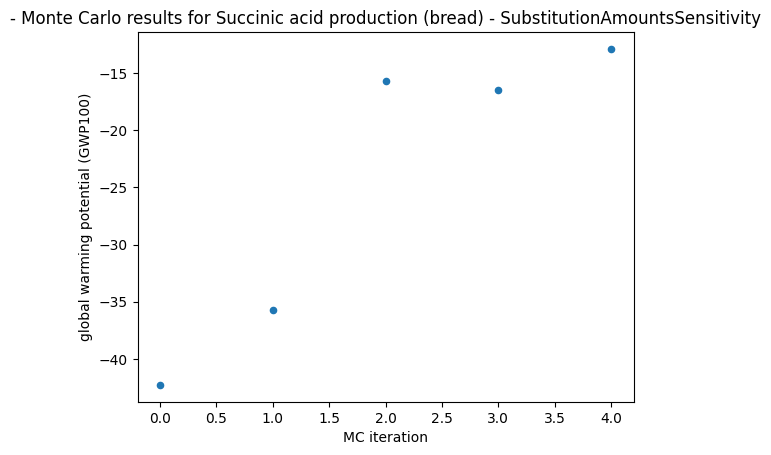

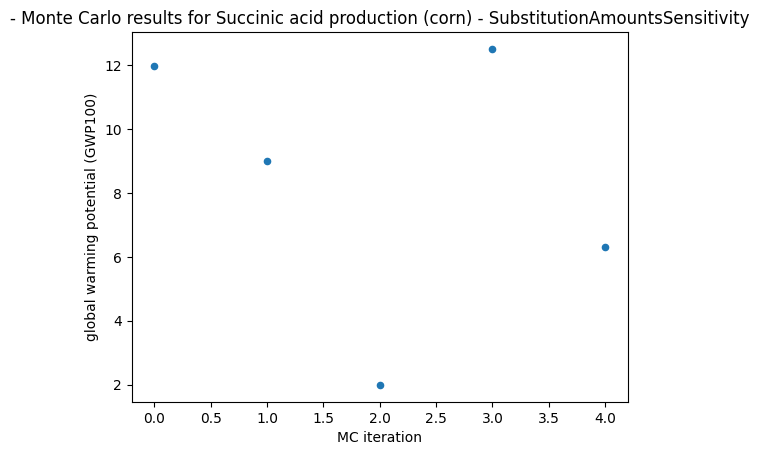

In [6]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -5.23565574793525
p = 3.72e-03
stat_MW = 0.0
p_PS = 7.94e-03
stat_KS = 1.0
p_KS = 7.94e-03
*** Welch's t-test
stat = -5.24
p = 3.72e-03
*** Mann-Whitney U test
stat = 0.00
p = 7.94e-03
*** Kolmogorov-Smirnov test
stat = 1.00
p = 7.94e-03


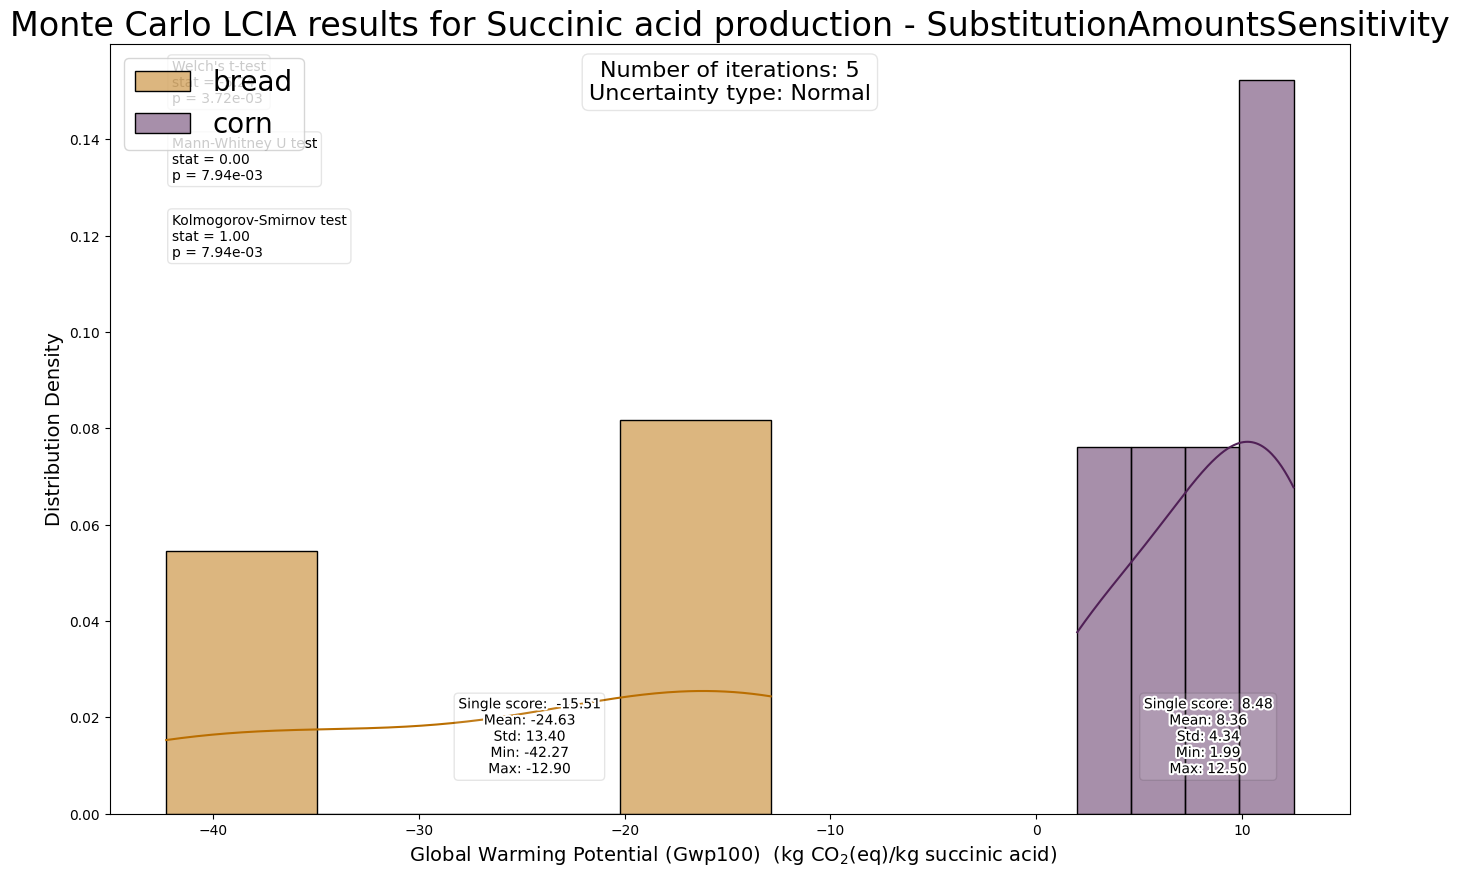

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -15.51kg CO2eq / kg  ***                          |
| count, 5.0                                        |
| mean, -24.625713630286658                         |
| std, 13.399665920168545                           |
| min, -42.27273599305349                           |
| 25%, -35.7491369072791                            |
| 50%, -16.4964725390162                            |
| 75%, -15.709038008524054                          |
| max, -12.90118470356044                           |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [7]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint

In [8]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [9]:
# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
recalculate = True
recalculate_MC = True
revisualise = True
redo_diagrams = False

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 5 # because running on codespace (see the results for 10000 iterations)
scale_percent = 0.3
dist_id = 3 # normal - 2 is lognormal 
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity
scenario_name = "base_case"
scenarios = {
    'SubstitutionAmountsSensitivity': True,
    "CoproductsToWaste": False,
    "EnergyEfficient": False,
    "WaterEfficient": False,
    "CoproductsToLowerMarket": False,
}

In [10]:
# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 06/01/2023 15:42:17
  Finished: 06/01/2023 15:42:17
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.48
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-06-01T15:42:17.246591', 'geocollections': [], 'searchable': True, 'processed': '2023-06-01T15:42:17.279117', 'dirty': False}

   ACTIVITY:  
*****************************
Bacterial fermentation (bread) : kg : Bacterial fermentation (bread)
----------------------------
	TECHNOSPHERE EXCHANGES: 7
 *  Exchange: 0.5 kilogram 'treatment of biowaste, industrial composting' (kilogram, RoW, None) to 'Bacterial fermentation (bread)' (kg, None, None)>
 *  Exchange: 0.106 kilogram 'market for neutralising agent, sodium hydroxide-equivalent' (kilogram, GL

In [11]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'SubstitutionAmountsSensitivity':
                factor = 0.5
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                edge[0]['amount'] *= factor
                print(f"Changed co-products substitution amout by a factor of {factor}: {edge}")
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'CoproductsToLowerMarket':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='16b7ce830141a933f9537e199cbd608e') # 'treatment of biowaste, industrial composting'
                # if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill' 
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

if scenario_name == 'base_case':
    print("No scenario selected, running base case")


    # nodes, edges, model = extract_nodes_edges(model)
    # write_process_diagram(nodes, edges, model, scenario_name)


***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -2.886 kilogram 'market for soybean meal' (kilogram, RoW, None) to 'Purification (bread)' (kg, None, None)>]

***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -1.36 kilogram 'market for ammonium sulfate' (kilogram, RER, None) to 'Purification (corn)' (kg, None, None)>]


In [12]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Su


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	 SubstitutionAmountsSensitivity : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count     5.000000
mean    -33.892242
st

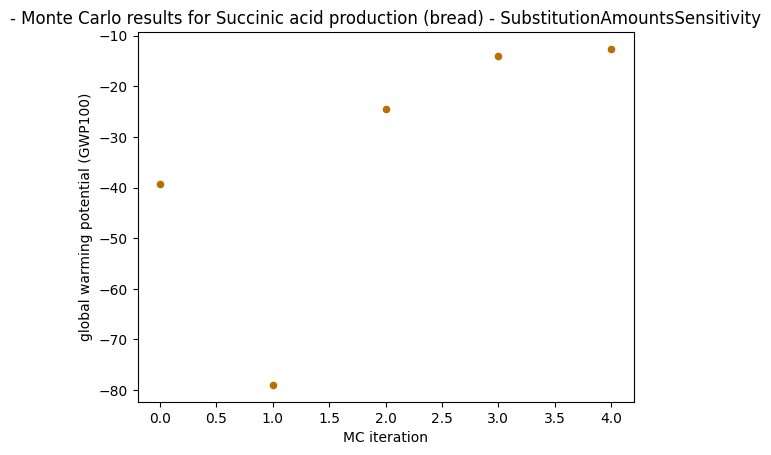

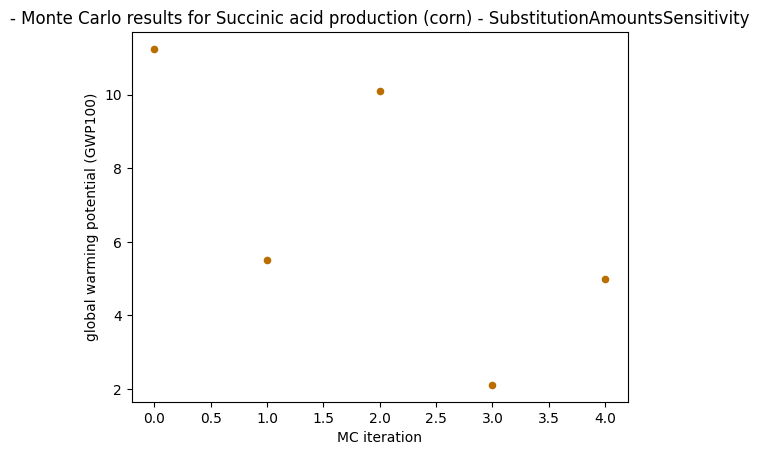

In [13]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -3.2903708452423612
p = 2.86e-02
stat_MW = 0.0
p_PS = 7.94e-03
stat_KS = 1.0
p_KS = 7.94e-03
*** Welch's t-test
stat = -3.29
p = 2.86e-02
*** Mann-Whitney U test
stat = 0.00
p = 7.94e-03
*** Kolmogorov-Smirnov test
stat = 1.00
p = 7.94e-03


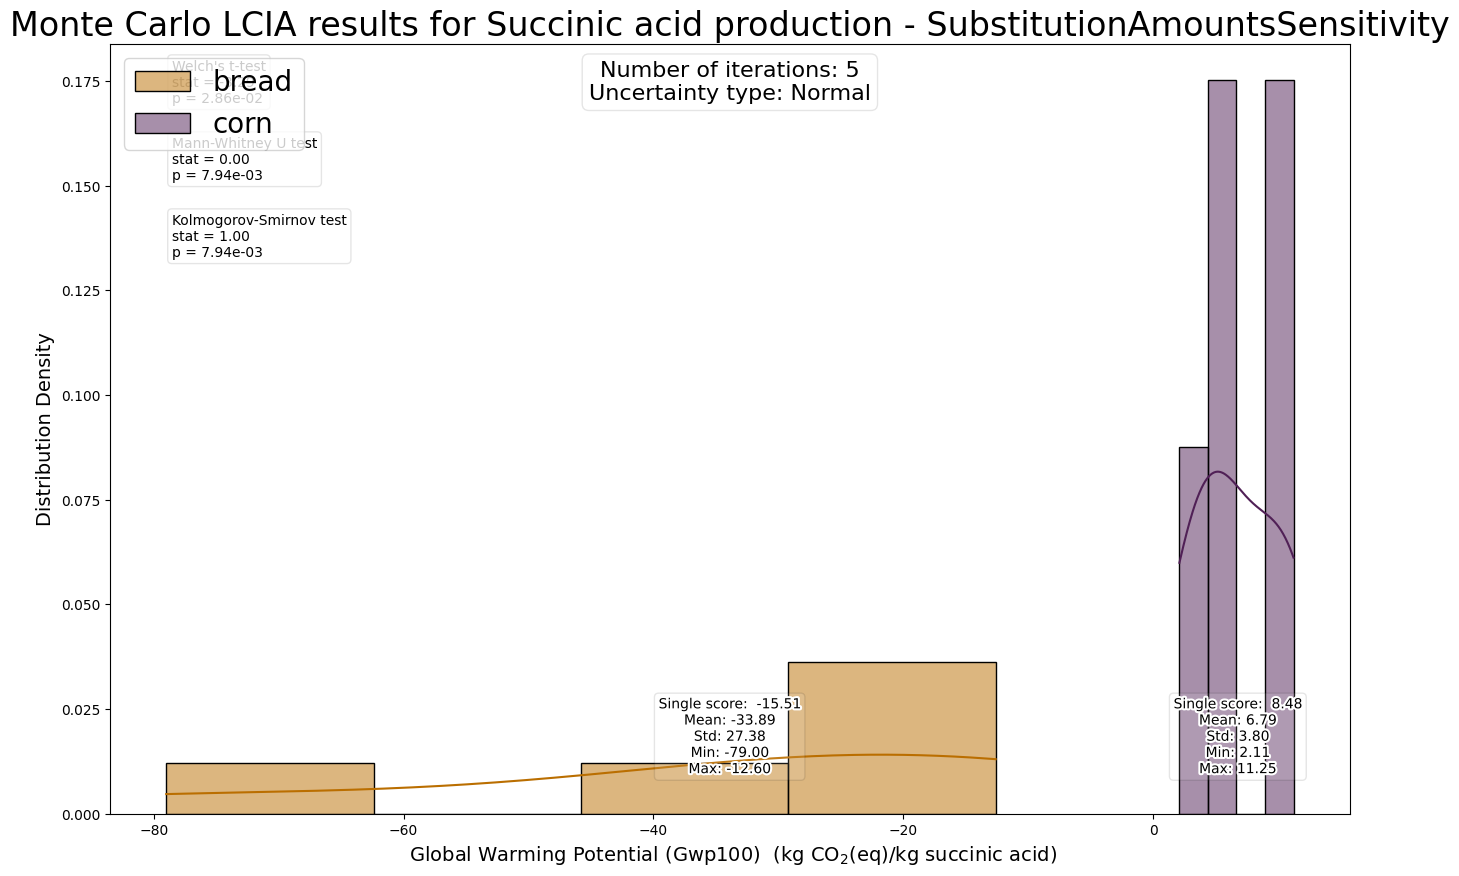

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -15.51kg CO2eq / kg  ***                          |
| count, 5.0                                        |
| mean, -33.89224187985115                          |
| std, 27.38402919932034                            |
| min, -78.99610754936762                           |
| 25%, -39.29697341858228                           |
| 50%, -24.566530909651764                          |
| 75%, -14.003100287831824                          |
| max, -12.598497233822265                          |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [14]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint

In [15]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [16]:
# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
recalculate = True
recalculate_MC = True
revisualise = True
redo_diagrams = False

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 5 # because running on codespace (see the results for 10000 iterations)
scale_percent = 0.3
dist_id = 3 # normal - 2 is lognormal 
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity
scenario_name = "base_case"
scenarios = {
    'SubstitutionAmountsSensitivity': True,
    "CoproductsToWaste": False,
    "EnergyEfficient": False,
    "WaterEfficient": False,
    "CoproductsToLowerMarket": False,
}

In [17]:
# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 06/01/2023 15:42:57
  Finished: 06/01/2023 15:42:57
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.67
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-06-01T15:42:57.469335', 'geocollections': [], 'searchable': True, 'processed': '2023-06-01T15:42:57.502872', 'dirty': False}

   ACTIVITY:  
*****************************
Pre-treatment (bread) : kg : Pre-treatment (bread)
----------------------------
	TECHNOSPHERE EXCHANGES: 5
 *  Exchange: 0.0 kg 'Bread waste' (kg, None, None) to 'Pre-treatment (bread)' (kg, None, None)>
 *  Exchange: 0.003676 kilogram 'market for enzymes' (kilogram, GLO, None) to 'Pre-treatment (bread)' (kg, None, None)>
 *  Exchange: 0.182556 kilowatt hour 'market group for

In [18]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'SubstitutionAmountsSensitivity':
                factor = 0.5
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                edge[0]['amount'] *= factor
                print(f"Changed co-products substitution amout by a factor of {factor}: {edge}")
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'CoproductsToLowerMarket':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='16b7ce830141a933f9537e199cbd608e') # 'treatment of biowaste, industrial composting'
                # if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill' 
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

if scenario_name == 'base_case':
    print("No scenario selected, running base case")


    # nodes, edges, model = extract_nodes_edges(model)
    # write_process_diagram(nodes, edges, model, scenario_name)


***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -2.886 kilogram 'market for soybean meal' (kilogram, RoW, None) to 'Purification (bread)' (kg, None, None)>]

***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -1.36 kilogram 'market for ammonium sulfate' (kilogram, RER, None) to 'Purification (corn)' (kg, None, None)>]


In [19]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Su


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	 SubstitutionAmountsSensitivity : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count     5.000000
mean    -29.957616
st

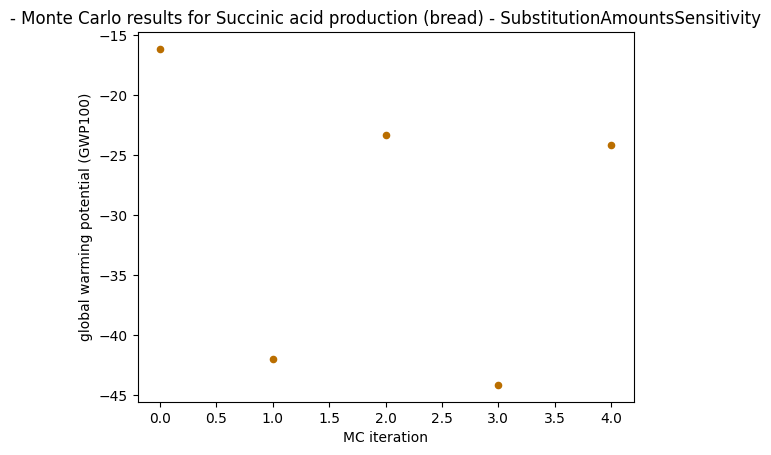

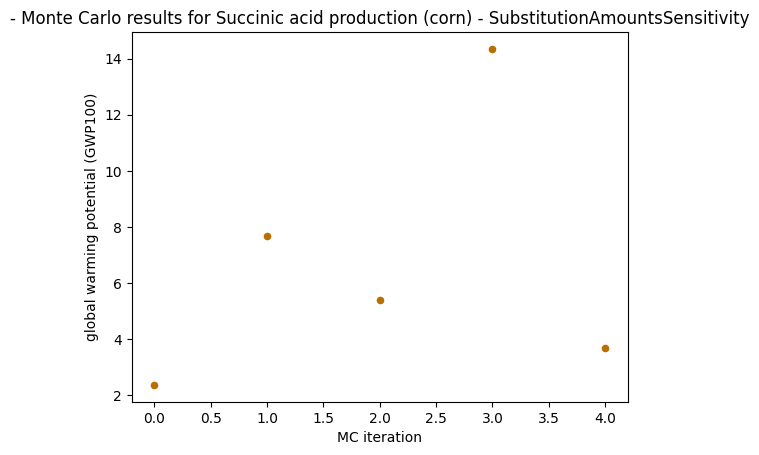

In [20]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -6.174019415750214
p = 1.47e-03
stat_MW = 0.0
p_PS = 7.94e-03
stat_KS = 1.0
p_KS = 7.94e-03
*** Welch's t-test
stat = -6.17
p = 1.47e-03
*** Mann-Whitney U test
stat = 0.00
p = 7.94e-03
*** Kolmogorov-Smirnov test
stat = 1.00
p = 7.94e-03


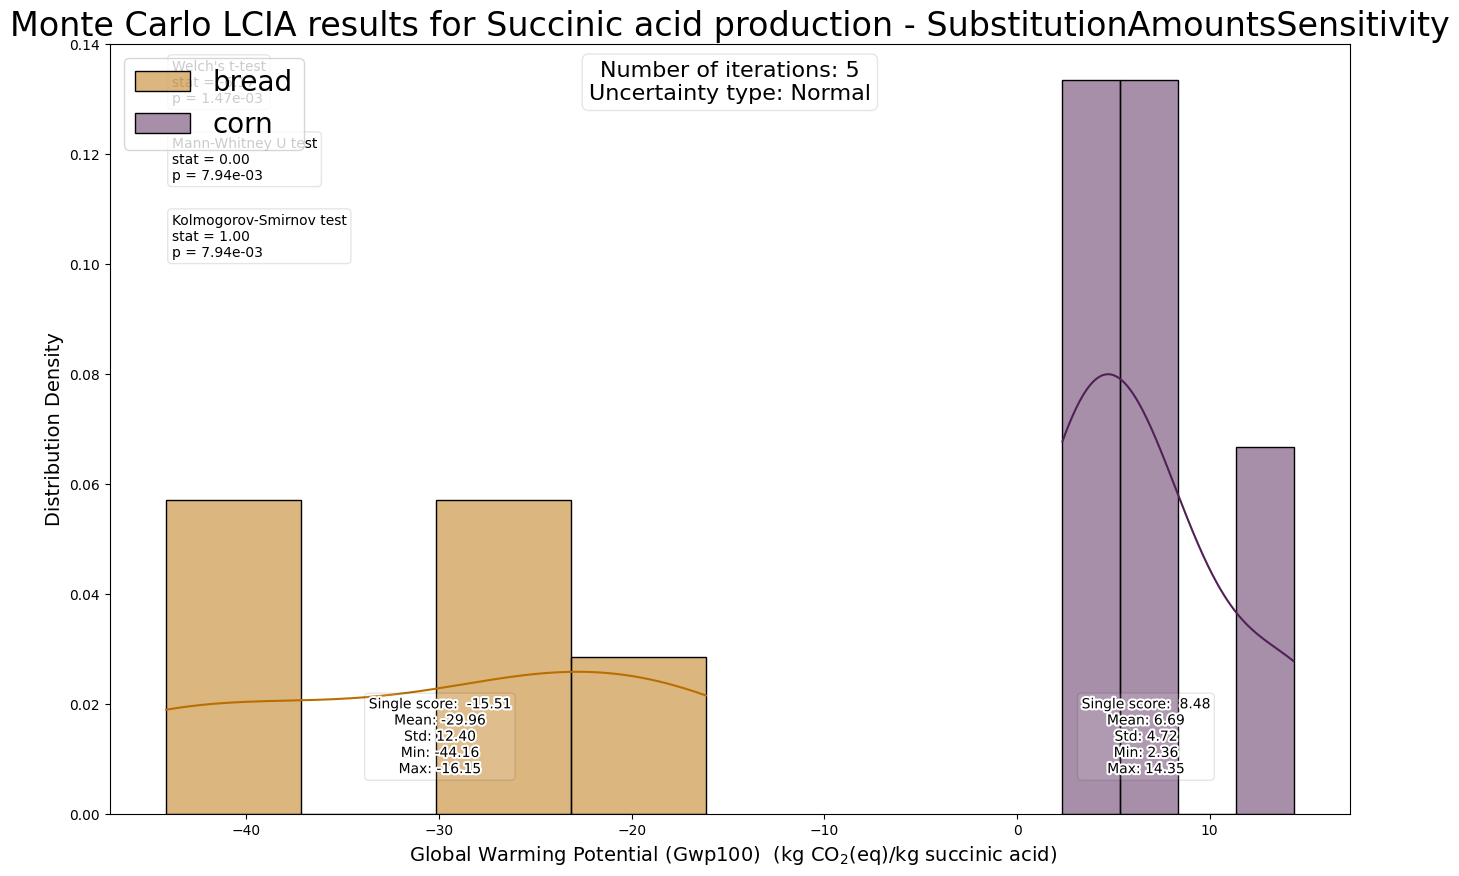

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -15.51kg CO2eq / kg  ***                          |
| count, 5.0                                        |
| mean, -29.957616436979002                         |
| std, 12.403083898850324                           |
| min, -44.15835038953443                           |
| 25%, -42.00927555068348                           |
| 50%, -24.16291158969348                           |
| 75%, -23.30686684300899                           |
| max, -16.150677811974635                          |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [21]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint

In [22]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [23]:
# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
recalculate = True
recalculate_MC = True
revisualise = True
redo_diagrams = False

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 100 # because running on codespace (see the results for 10000 iterations)
scale_percent = 0.3
dist_id = 3 # normal - 2 is lognormal 
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity
scenario_name = "base_case"
scenarios = {
    'SubstitutionAmountsSensitivity': True,
    "CoproductsToWaste": False,
    "EnergyEfficient": False,
    "WaterEfficient": False,
    "CoproductsToLowerMarket": False,
}

In [24]:
# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 06/01/2023 15:43:54
  Finished: 06/01/2023 15:43:54
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.68
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-06-01T15:43:54.713627', 'geocollections': [], 'searchable': True, 'processed': '2023-06-01T15:43:54.746833', 'dirty': False}

   ACTIVITY:  
*****************************
Bacterial fermentation (bread) : kg : Bacterial fermentation (bread)
----------------------------
	TECHNOSPHERE EXCHANGES: 7
 *  Exchange: 0.5 kilogram 'treatment of biowaste, industrial composting' (kilogram, RoW, None) to 'Bacterial fermentation (bread)' (kg, None, None)>
 *  Exchange: 0.106 kilogram 'market for neutralising agent, sodium hydroxide-equivalent' (kilogram, GL

In [25]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'SubstitutionAmountsSensitivity':
                factor = 0.5
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                edge[0]['amount'] *= factor
                print(f"Changed co-products substitution amout by a factor of {factor}: {edge}")
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'CoproductsToLowerMarket':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='16b7ce830141a933f9537e199cbd608e') # 'treatment of biowaste, industrial composting'
                # if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill' 
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

if scenario_name == 'base_case':
    print("No scenario selected, running base case")


    # nodes, edges, model = extract_nodes_edges(model)
    # write_process_diagram(nodes, edges, model, scenario_name)


***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -2.886 kilogram 'market for soybean meal' (kilogram, RoW, None) to 'Purification (bread)' (kg, None, None)>]

***************** Scenario: SubstitutionAmountsSensitivity *****************

Changed co-products substitution amout by a factor of 0.5: [Exchange: -1.36 kilogram 'market for ammonium sulfate' (kilogram, RER, None) to 'Purification (corn)' (kg, None, None)>]


In [26]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Su


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 SubstitutionAmountsSensitivity: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -15.51 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	 SubstitutionAmountsSensitivity : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count    100.000000
mean     -28.287864


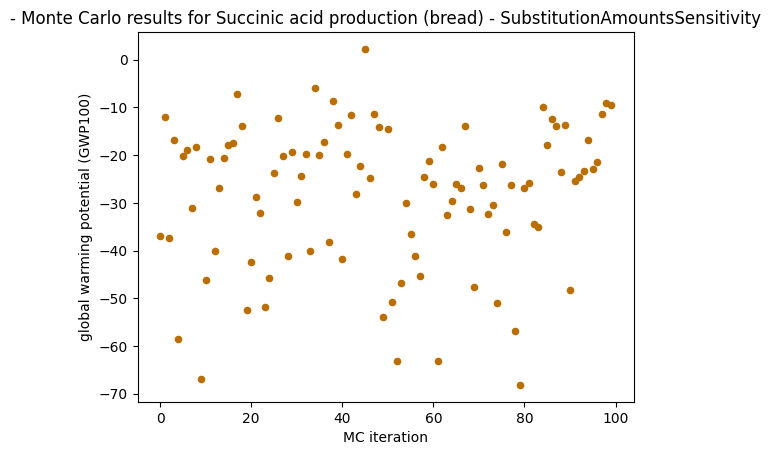

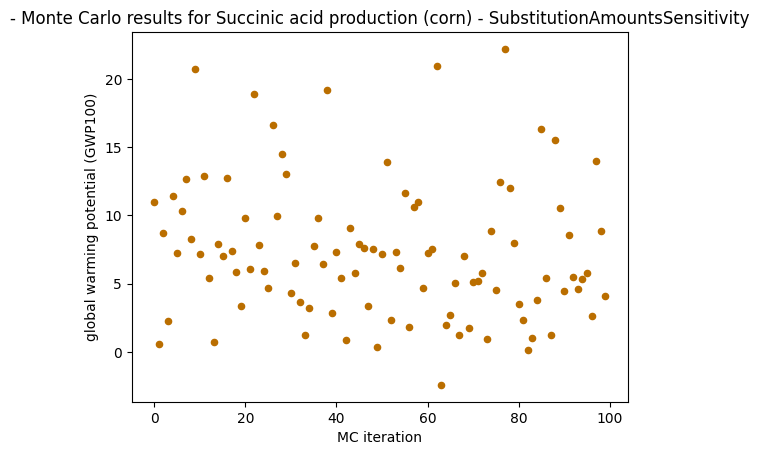

In [27]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -22.652662512276432
p = 2.38e-45
stat_MW = 15.0
p_PS = 4.02e-34
stat_KS = 0.99
p_KS = 4.42e-57
*** Welch's t-test
stat = -22.65
p = 2.38e-45
*** Mann-Whitney U test
stat = 15.00
p = 4.02e-34
*** Kolmogorov-Smirnov test
stat = 0.99
p = 4.42e-57


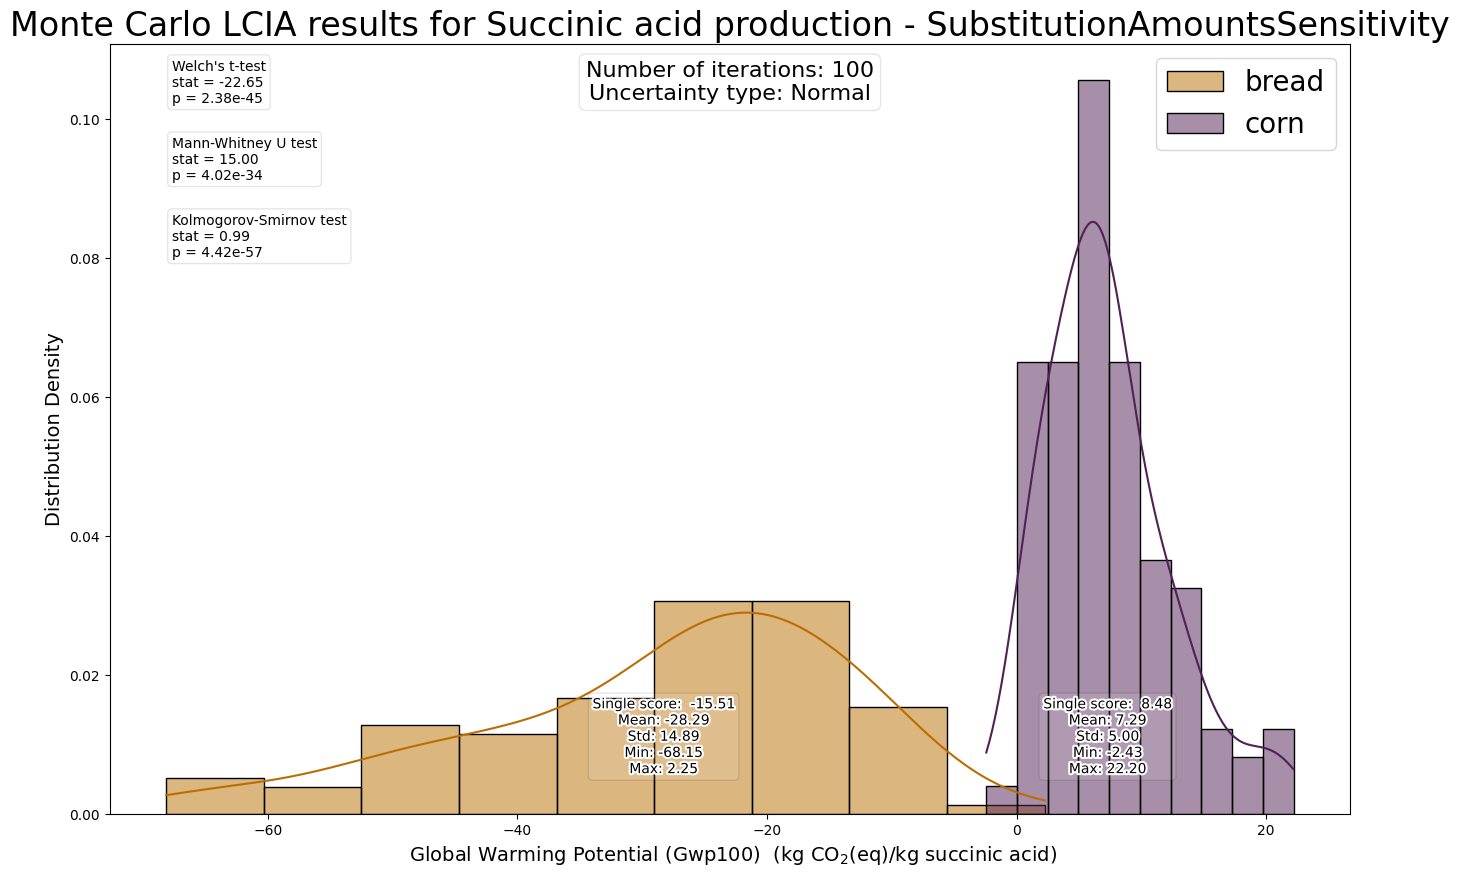

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -15.51kg CO2eq / kg  ***                          |
| count, 100.0                                      |
| mean, -28.287863920200984                         |
| std, 14.889930297857402                           |
| min, -68.14835538082076                           |
| 25%, -37.09886988528367                           |
| 50%, -25.098014560725083                          |
| 75%, -17.85220459895038                           |
| max, 2.2492266371540834                           |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [28]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint